In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from util_functions import colour_class, load_sound_files, energy, rmse

In [5]:
#Loading all the files and obtaining different lists with features
sound_files_path = '../data/cats_dogs/'
sr,raw_sounds,raw_labels = load_sound_files(sound_files_path)

energy_array, rmse_array, tempo_array, pitch_array, mfcc1_array, mfcc2_array, mfcctotal_array = [],[],[],[],[],[],[]
for f in raw_sounds:
    energy_array.append(energy(f))
    rmse_array.append(rmse(f))
    tempo,  _ = librosa.beat.beat_track(y=f, sr=sr)
    tempo_array.append(tempo)
    pitches, magnitudes = librosa.piptrack(y=f)
    pitch_array.append(sum(sum(abs(pitches)))/pitches.size)
    mfcc=librosa.feature.mfcc(y=f)
    mfcc1_array.append(sum(abs(mfcc[0,:]))/mfcc[0,:].size)
    mfcc2_array.append(sum(abs(mfcc[1,:]))/mfcc[1,:].size)
    mfcctotal_array.append(sum(sum(abs(mfcc)))/mfcc.size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/librosa/filters.py:271: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


## Plotting Different features to observe cluster definition

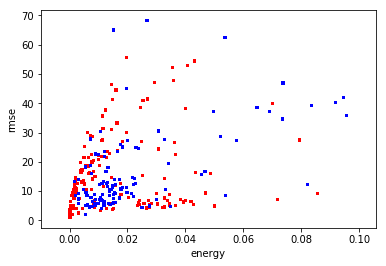

In [6]:
colours = [colour_class(x) for x in np.array(raw_labels)]
plt.scatter(energy_array, rmse_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('energy')
plt.ylabel('rmse')
plt.show()

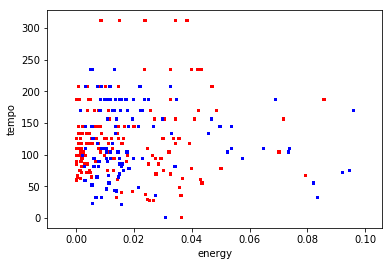

In [7]:
plt.scatter(energy_array, tempo_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('energy')
plt.ylabel('tempo')
plt.show()

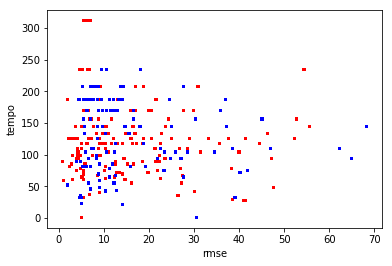

In [8]:
plt.scatter(rmse_array, tempo_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('rmse')
plt.ylabel('tempo')
plt.show()

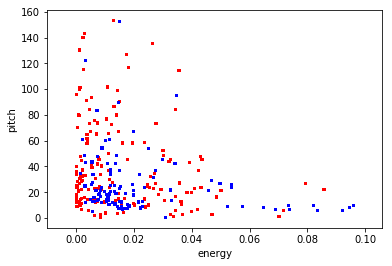

In [9]:
plt.scatter(energy_array, pitch_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('energy')
plt.ylabel('pitch')
plt.show()

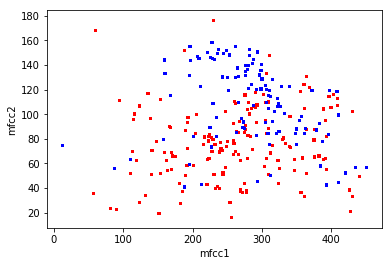

In [10]:
plt.scatter(mfcc1_array, mfcc2_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('mfcc1')
plt.ylabel('mfcc2')
plt.show()

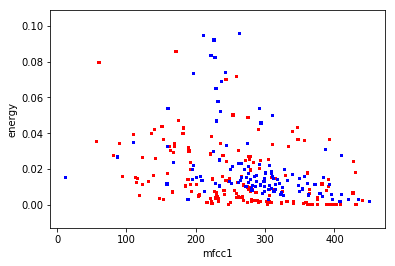

In [11]:
plt.scatter(mfcc1_array, energy_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('mfcc1')
plt.ylabel('energy')
plt.show()

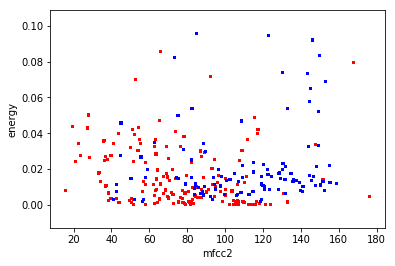

In [12]:
plt.scatter(mfcc2_array, energy_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('mfcc2')
plt.ylabel('energy')
plt.show()

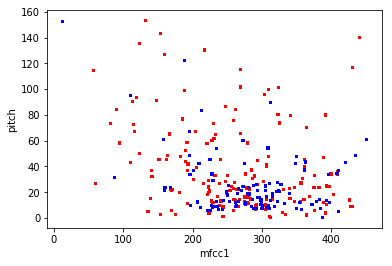

In [13]:
plt.scatter(mfcc1_array, pitch_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('mfcc1')
plt.ylabel('pitch')
plt.show()

### This one looks promising, absolute values of the MFCC’s versus the normalized energy

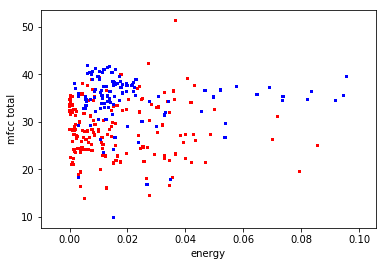

In [14]:
plt.scatter(energy_array, mfcctotal_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('energy')
plt.ylabel('mfcc total')
plt.show()

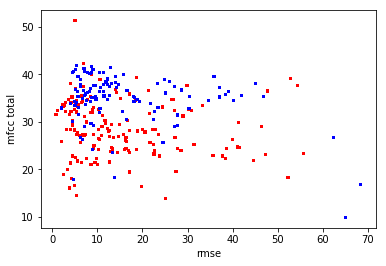

In [15]:
plt.scatter(rmse_array, mfcctotal_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('rmse')
plt.ylabel('mfcc total')
plt.show()

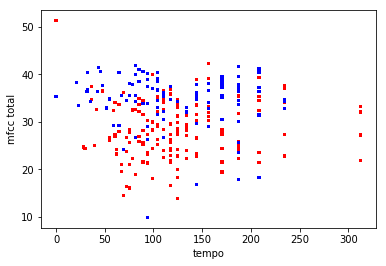

In [16]:
plt.scatter(tempo_array, mfcctotal_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('tempo')
plt.ylabel('mfcc total')
plt.show()

### This one looks promising, absolute values of the MFCC’s versus the pitch

Dogs appear to be very clustered together (in blue)

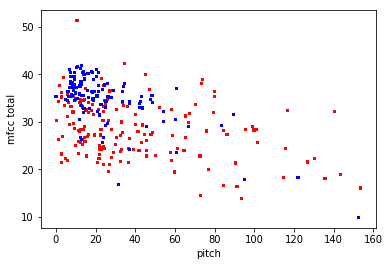

In [17]:
plt.scatter(pitch_array, mfcctotal_array,color=colours,marker=',',lw=0, s=10)
plt.xlabel('pitch')
plt.ylabel('mfcc total')
plt.show()

### Let's do some clustering to support the two hypothesis of features.

1 - absolute values of the MFCC’s versus the normalized energy

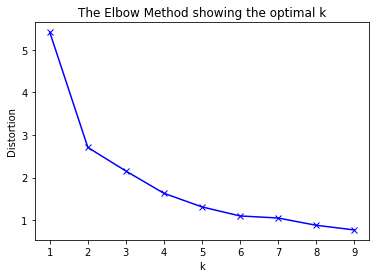

In [18]:
# k means determine k
distortions = []
X=np.transpose(np.array([mfcctotal_array, energy_array]))

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
#Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

This shows us that the elbow is at k=2 which is quite nice as we know we have two classes!

Let us use these two classes to implement a classifier

In [19]:
X=np.transpose(np.array([mfcctotal_array, energy_array]))

# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, raw_labels, test_size=0.25, random_state=59)

# instantiate learning model (k = 2)
knn = KNeighborsClassifier(n_neighbors=2)

# fitting the model
knn.fit(X_train, y_train)

# predict the response and get confusion matrix
pred = knn.predict(X_test)
con_mat = confusion_matrix(y_test, pred, [0, 1])

#Print summary
total_accuracy = (con_mat[0, 0] + con_mat[1, 1]) / float(np.sum(con_mat))
class1_accuracy = (con_mat[0, 0] / float(np.sum(con_mat[0, :])))
class2_accuracy = (con_mat[1, 1] / float(np.sum(con_mat[1, :])))
print(con_mat)
print('Total accuracy: %.5f' % total_accuracy)
print('Class1 accuracy: %.5f' % class1_accuracy)
print('Class2 accuracy: %.5f' % class2_accuracy)
print('Geometric mean accuracy: %.5f' % math.sqrt((class1_accuracy * class2_accuracy)))

[[31  7]
 [22 10]]
Total accuracy: 0.58571
Class1 accuracy: 0.81579
Class2 accuracy: 0.31250
Geometric mean accuracy: 0.50491


### For our second classifier

2 - absolute values of the MFCC’s versus pitch

In [43]:
X=np.transpose(np.array([mfcctotal_array, pitch_array]))

# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, raw_labels, test_size=0.25, random_state=59)

# instantiate learning model (k = 2)
knn = KNeighborsClassifier(n_neighbors=2)

# fitting the model
knn.fit(X_train, y_train)

# predict the response and get confusion matrix
pred = knn.predict(X_test)
con_mat = confusion_matrix(y_test, pred, [0, 1])

#Print summary
total_accuracy = (con_mat[0, 0] + con_mat[1, 1]) / float(np.sum(con_mat))
class1_accuracy = (con_mat[0, 0] / float(np.sum(con_mat[0, :])))
class2_accuracy = (con_mat[1, 1] / float(np.sum(con_mat[1, :])))
print(con_mat)
print('Total accuracy: %.5f' % total_accuracy)
print('Class1 accuracy: %.5f' % class1_accuracy)
print('Class2 accuracy: %.5f' % class2_accuracy)
print('Geometric mean accuracy: %.5f' % math.sqrt((class1_accuracy * class2_accuracy)))

[[32  6]
 [20 12]]
Total accuracy: 0.62857
Class1 accuracy: 0.84211
Class2 accuracy: 0.37500
Geometric mean accuracy: 0.56195
